In [7]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces in an image and return the cropped faces
def detect_faces(img, target_size=(224, 224)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    face_imgs = []

    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]
        face = cv2.resize(face, target_size)
        face_imgs.append(face)
    
    return face_imgs

# Function to preprocess images
def preprocess_images(imgs):
    img_arrays = np.array([img.astype('float32') / 255.0 for img in imgs])
    return img_arrays

# Function to process all images in a directory and return detected faces
def process_directory(directory, target_size=(224, 224)):
    all_faces = []
    all_labels = []

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                faces = detect_faces(img, target_size)
                
                if faces:
                    faces_preprocessed = preprocess_images(faces)
                    all_faces.extend(faces_preprocessed)
                    label = os.path.basename(root)
                    all_labels.extend([label] * len(faces_preprocessed))
    
    return np.array(all_faces), np.array(all_labels)

# Example usage: process train, test, and validation directories
train_dir = 'D:\\ELC_2024\\Accidence Avoidance\\Dataset_seg - Copy\\train'
val_dir = "D:\\ELC_2024\\Accidence Avoidance\\Dataset_seg - Copy\\val"
# test_dir = 'D:\\final\\test'

x_train, y_train = process_directory(train_dir)
x_val, y_val = process_directory(val_dir)
#x_test, y_test = process_directory(test_dir)

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
#y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded)
y_val_one_hot = to_categorical(y_val_encoded)
#y_test_one_hot = to_categorical(y_test_encoded)

# Create the base DenseNet121 model
densenet_base = DenseNet121(include_top=False, input_shape=(224, 224, 3))
x = Flatten()(densenet_base.output)
x = Dense(512, activation='relu')(x)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)  # Adjust the number of classes
model = Model(inputs=densenet_base.input, outputs=output)

# Freeze the layers of the base model
for layer in densenet_base.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Train the model
history=model.fit(
    x_train, y_train_one_hot,
    epochs=25,
    validation_data=(x_val, y_val_one_hot),
    callbacks=[early_stop],
    batch_size=32,
    shuffle=True
)

# Save the trained model
#model.save('DenseNet121_Trained_Model.h5')


Epoch 1/25
562/562 ━━━━━━━━━━━━━━━━━━━━ 335s 576ms/step - accuracy: 0.5852 - loss: 4.7087 - val_accuracy: 0.7454 - val_loss: 0.6934
Epoch 2/25
562/562 ━━━━━━━━━━━━━━━━━━━━ 303s 540ms/step - accuracy: 0.7484 - loss: 0.6546 - val_accuracy: 0.7693 - val_loss: 0.6156
Epoch 3/25
562/562 ━━━━━━━━━━━━━━━━━━━━ 302s 537ms/step - accuracy: 0.7792 - loss: 0.5790 - val_accuracy: 0.7713 - val_loss: 0.6024
Epoch 4/25
562/562 ━━━━━━━━━━━━━━━━━━━━ 302s 537ms/step - accuracy: 0.8062 - loss: 0.5012 - val_accuracy: 0.7834 - val_loss: 0.5716
Epoch 5/25
562/562 ━━━━━━━━━━━━━━━━━━━━ 301s 536ms/step - accuracy: 0.8276 - loss: 0.4541 - val_accuracy: 0.7924 - val_loss: 0.5756
Epoch 6/25
562/562 ━━━━━━━━━━━━━━━━━━━━ 299s 532ms/step - accuracy: 0.8392 - loss: 0.4209 - val_accuracy: 0.7621 - val_loss: 0.7079
Epoch 7/25
562/562 ━━━━━━━━━━━━━━━━━━━━ 298s 530ms/step - accuracy: 0.8344 - loss: 0.4284 - val_accuracy: 0.7832 - val_loss: 0.6061
Epoch 8/25
562/562 ━━━━━━━━━━━━━━━━━━━━ 298s 530ms/step - accuracy: 0.8445 -

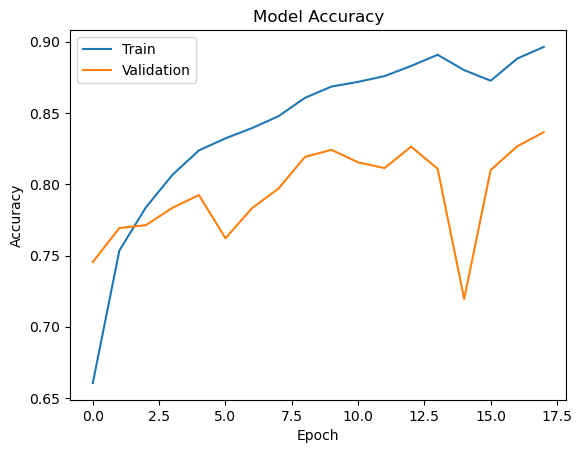

In [9]:
# Plot the accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [4]:
model.save("D:\\ELC_2024\\Accidence Avoidance\\DenseNet\\DenseNet121_New.keras")

In [5]:
import cv2
import numpy as np
import face_recognition
from keras.models import load_model

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load your trained VGG16 model
model_vgg16 = load_model("D:\\ELC_2024\\Accidence Avoidance\\DenseNet\\DenseNet121_New.keras")

# Define the labels
labels = ['CLOSED_EYES', 'DROWSY', 'HALF_OPEN', 'NEUTRAL', 'YAWNING']  # Replace with your actual labels

# Function to calculate the Eye Aspect Ratio (EAR)
def eye_aspect_ratio(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

# Function to calculate the Mouth Aspect Ratio (MAR)
def mouth_aspect_ratio(mouth):
    # Calculate the euclidean distances between the vertical landmarks of the mouth
    A = np.linalg.norm(mouth[2] - mouth[10])  # upper_lip_top - lower_lip_bottom
    B = np.linalg.norm(mouth[4] - mouth[8])   # upper_lip_bottom - lower_lip_top
    # Calculate the euclidean distance between the horizontal landmarks of the mouth
    C = np.linalg.norm(mouth[0] - mouth[6])   # left_corner - right_corner
    # Calculate MAR
    mar = (A + B) / (2.0 * C)
    return mar

# Function to preprocess images for VGG16
def preprocess_image(img, target_size=(224, 224)):
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Capture video from webcam
cap = cv2.VideoCapture(0)  # Use 0 for the default webcam

# Check if the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Frame rate (frames per second)
frame_rate = 30

# Calculate the interval between frames in milliseconds
frame_interval = int(1000 / frame_rate)

# Threshold for mouth aspect ratio to determine if mouth is open
mouth_open_threshold = 0.15  # Adjust as needed

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if not ret:
        print("Error: Failed to capture image")
        break

    # Convert the frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces using Haar Cascade
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Detect landmarks using face_recognition
        face_landmarks_list = face_recognition.face_landmarks(face)
        if not face_landmarks_list:
            continue
        
        face_landmarks = face_landmarks_list[0]
        
        # Get the landmarks for the eyes and mouth
        left_eye = np.array(face_landmarks['left_eye'])
        right_eye = np.array(face_landmarks['right_eye'])
        top_lip = np.array(face_landmarks['top_lip'])
        bottom_lip = np.array(face_landmarks['bottom_lip'])
        mouth = np.concatenate((top_lip, bottom_lip), axis=0)
        
        # Draw the landmarks on the frame
        for (ex, ey) in left_eye:
            cv2.circle(face, (ex, ey), 2, (0, 255, 0), -1)
        for (ex, ey) in right_eye:
            cv2.circle(face, (ex, ey), 2, (0, 255, 0), -1)
        for (ex, ey) in mouth:
            cv2.circle(face, (ex, ey), 2, (0, 255, 0), -1)
        
        # Calculate EAR
        ear_left = eye_aspect_ratio(left_eye)
        ear_right = eye_aspect_ratio(right_eye)
        
        # Calculate MAR
        mar = mouth_aspect_ratio(mouth)
        
        # Determine the label based on EAR and mouth state
        if mar > mouth_open_threshold:
            label = 'YAWNING'
        elif ear_left > 0.28 and ear_right > 0.28:
            label = 'NEUTRAL'
        elif ear_left < 0.25 and ear_right < 0.25:
            label = 'CLOSED_EYES'
        elif 0.25 <= ear_left < 0.28 or 0.25 <= ear_right < 0.28:
            label = 'HALF_OPEN'
        else:
            face_preprocessed = preprocess_image(face)
            prediction = model_vgg16.predict(face_preprocessed)
            label_index = np.argmax(prediction)
            label = labels[label_index]
        
        # Display the label on the frame
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    # Display the resulting frame
    cv2.imshow('Video', frame)
    
    # Break the loop when 'q' is pressed
    if cv2.waitKey(frame_interval) & 0xFF == ord('q'):
        break

# Release the capture and destroy all windows
cap.release()
cv2.destroyAllWindows()
